# Classification de texte avec un RNN


Le but de ce TP est de fournir un aperçu complet de l'utilisation des réseaux de neurones récurrents (RNN) dans le domaine de la classification de texte. Nous nous concentrons spécifiquement sur l'application des RNN pour l'analyse des sentiments, en utilisant l'ensemble de données de critiques de films IMDB comme principal cas d'étude.

# Importe les bibliothèques nécessaires

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

# En Charge l'ensemble de données "imdb_reviews" à partir de TensorFlow Datasets.

In [42]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Affichage itératif des 5 premiers exemples et étiquettes du dataset d'entraînement.

In [43]:
for i in range(1,5):
  print("-----------------------------"+str(i)+"----------------------------")
  for example, label in train_dataset.take(i):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

-----------------------------1----------------------------
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
-----------------------------2----------------------------
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply

# Prétraitement et affichage des 10 premiers exemples et étiquettes du dataset d'entraînement.

In [44]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [45]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [46]:
for i in range(1,5):
  for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'Let me start by saying that I\'d read a number of reviews before renting this film and kind of knew what to expect. Still, I was surprised by just how bad it was. <br /><br />I am a big werewolf fan, and have grown accustomed to forgiving a great deal when watching one. Most of them have sub-par effects, poor acting, and weak storylines (at best rehashed from earlier films). So far, with the possible exception of some of the later "Howling" series films, this is the worst of the lot.<br /><br />First, the story. It\'s been quoted several times in reviews on this site, so I won\'t go into specifics. However, it is very obvious that the writer(s) had absolutely no affinity for lycanthropic monsters. As so often happens when a horror film is given to a writer who considers themselves "above" such fare, they tried to come up with a new spin on the werewolf mythos. That\'s fine, but a non-horror fan trying to do this generally has disregard for the intelligence and sophistication

# Création de l'encodeur de texte.

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Extraction des 20 premiers éléments du vocabulaire de l'encodeur de texte.

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

# Encodage des  exemples à l'aide de l'encodeur de texte.

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 220,   4, ...,   0,   0,   0],
       [  1,   1,   7, ...,   0,   0,   0],
       [ 11,  18, 268, ...,   0,   0,   0]])

# Comparaison entre les exemples originaux et les exemples encodés avec l'encodeur de texte.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Strained comedy, a sketch-like revue which was initially a vehicle to showcase one-time radio star Jack Pearl but is now best remembered as America's introduction to The Three Stooges. Actually, Larry, Curly and Moe are billed alongside comic Ted Healy as Ted Healy and his Three Stooges. Although the supporting cast features Jimmy Durante (who is completely wasted on dim material) and ZaSu Pitts, the only audience for the film these days are Stooges-addicts, and even they won't find much to applaud here. Incredibly loud and overbearing, it shows how far Hollywood had to go to reach a certain level of slapstick sophistication. *1/2 from ****"
Round-trip:  [UNK] comedy a [UNK] [UNK] which was [UNK] a [UNK] to [UNK] [UNK] [UNK] star jack [UNK] but is now best [UNK] as [UNK] [UNK] to the three [UNK] actually [UNK] [UNK] and [UNK] are [UNK] [UNK] comic [UNK] [UNK] as [UNK] [UNK] and his three [UNK] although the supporting cast features [UNK] [UNK] who is completely [UNK] on [UN

# Création d'un modèle séquentiel avec les couches suivantes :

1.   Encodeur de texte
2.   Couche d'incorporation (Embedding) avec une dimension d'entrée égale à la taille du vocabulaire de l'encodeur et une dimension de sortie de 64. La mise en masque (mask_zero=True) est utilisée pour gérer les longueurs variables de séquence.
3.   Couche Bidirectionnelle LSTM avec 64 unités.
5.   Couche Dense avec 64 unités et une activation ReLU.
4.   Couche Dense avec 1 unité (pour la classification binaire).

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Compilation du modèle avec une fonction de perte binaire BinaryCrossentropy adaptée aux logits, un optimiseur Adam avec un taux d'apprentissage de 1e-4 et des métriques de précision (accuracy).

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

le modèle est entraîné sur les données d'entraînement (train_dataset) pendant 10 époques,  en utilisant les données de validation (test_dataset) pour évaluer les performances du modèle après chaque époque. Le paramètre validation_steps=30 indique le nombre d'étapes de validation effectuées à chaque époque.

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 48s 99ms/step - loss: 0.6508 - accuracy: 0.5510 - val_loss: 0.5102 - val_accuracy: 0.7505
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.4222 - accuracy: 0.8036 - val_loss: 0.3723 - val_accuracy: 0.8318
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3426 - accuracy: 0.8504 - val_loss: 0.3444 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3230 - accuracy: 0.8613 - val_loss: 0.3407 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3116 - accuracy: 0.8688 - val_loss: 0.3267 - val_accuracy: 0.8484
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3062 - accuracy: 0.8691 - val_loss: 0.3207 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3024 - accuracy: 0.8707 - val_loss: 0.3220 - val_accuracy:

Évaluation du modèle sur le jeu de données de test (test_dataset). Le code calcule la perte de test (test_loss) et la précision de test (test_acc).

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3159 - accuracy: 0.8541
Test Loss: 0.3159213662147522
Test Accuracy: 0.8540800213813782


Définition de la fonction plot_graphs pour tracer les courbes de métriques d'apprentissage et de validation au fil des époques.

In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6685035586357116)

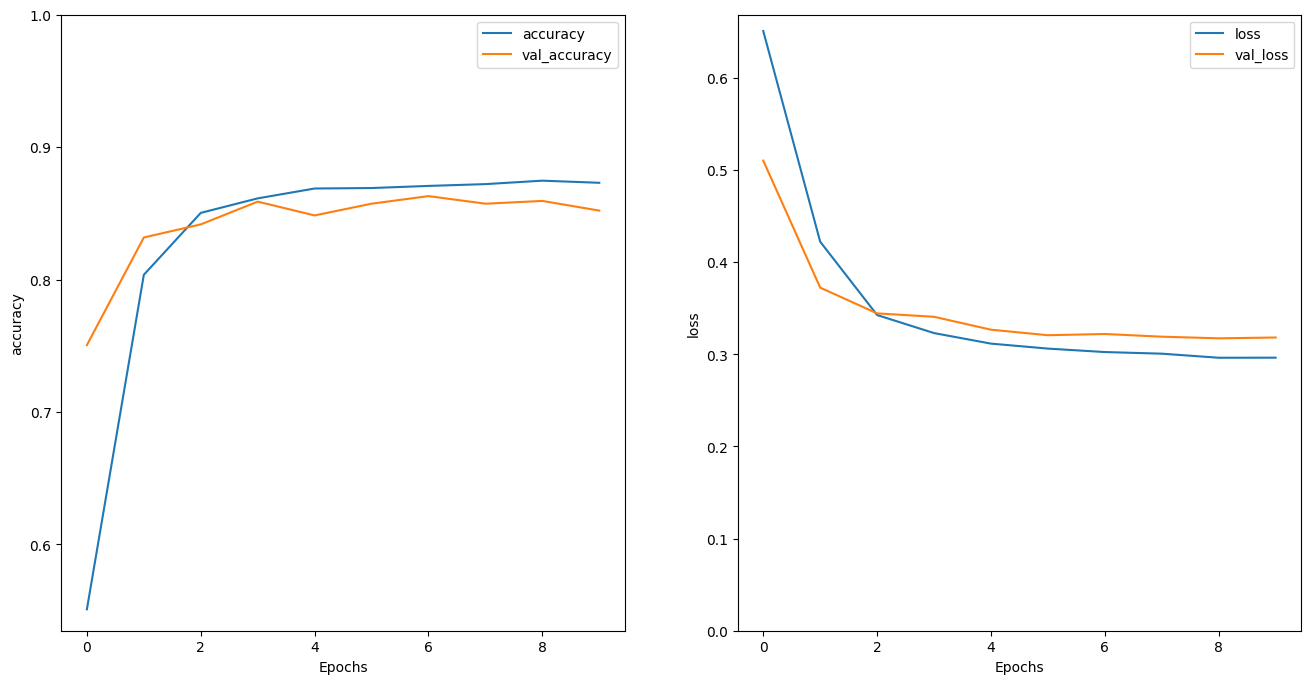

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

En conclusion, le code présenté met en œuvre un modèle de traitement de texte basé sur un réseau de neurones récurrents (LSTM) pour effectuer une tâche de classification binaire, telle que l'analyse de sentiments. Le modèle utilise un encodeur de texte pour convertir les séquences de mots en représentations numériques. Il est ensuite entraîné avec un ensemble de données d'entraînement et évalué sur un ensemble de données de test.